In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pybaseball import team_game_logs
from pybaseball import team_ids
from pybaseball import team_batting

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


import statsmodels.api as sm
import statsmodels.tools.eval_measures as sme

import import_ipynb
import functions as func

pd.set_option('display.max_columns', None)

importing Jupyter notebook from functions.ipynb


In [3]:
raw_data = pd.read_csv('data/PitchData_21.csv')
raw_data.drop(columns=raw_data.columns[0], inplace=True)

In [4]:
data = raw_data.copy()
# keep regular season games
data = data[data['game_type']=='R'].copy()

In [72]:
# create dummies for pitch event
dummies = pd.get_dummies(data['description'])
dummies.rename(columns=lambda x: x+'_dummy', inplace=True)
data = pd.concat((data, dummies), axis=1)

Statcast Stats Explained: https://baseballsavant.mlb.com/csv-docs
Strike Zone Size: https://baseballsavant.mlb.com/visuals/profile?pitch_type=&batter=&pitcher=&balls=&strikes=&year=2020&min_strikes=0&bucket_size=0.5&chart_type=swings&player_id=&position=&player_name=

In [73]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,ball_dummy,blocked_ball_dummy,bunt_foul_tip_dummy,called_strike_dummy,foul_dummy,foul_bunt_dummy,foul_pitchout_dummy,foul_tip_dummy,hit_by_pitch_dummy,hit_into_play_dummy,missed_bunt_dummy,pitchout_dummy,swinging_strike_dummy,swinging_strike_blocked_dummy
10786,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595.0,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10787,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-0.77,0.48,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315.0,0.000,-0.027,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10788,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-0.65,-0.51,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328.0,0.000,-0.020,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10789,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,NaN,ball,NaN,NaN,NaN,NaN,12.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,NaN,NaN,0,0,2021,-0.69,-0.69,2.10,3.89,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,NaN,NaN,NaN,74.5,2017.0,5.9,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330.0,0.000,0.016,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10790,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595.0,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9

In [74]:
data.shape

(709851, 106)

In [75]:
data['description'].unique()

array(['hit_into_play', 'foul', 'ball', 'swinging_strike_blocked',
       'called_strike', 'swinging_strike', 'foul_tip', 'blocked_ball',
       'foul_bunt', 'hit_by_pitch', 'missed_bunt', 'bunt_foul_tip',
       'pitchout', 'foul_pitchout'], dtype=object)

# drop rows with missing plate_x

In [76]:
data = data[data['plate_x'].notna()].copy()

In [77]:
data.shape

(709483, 106)

# determine strike zone dimension
# horizontal

In [78]:
# regular x boundraies
plateMinB = -8.5/12
plateMaxB = 8.5/12
plateMinB_True = plateMinB - 0.12
plateMaxB_True = plateMaxB + 0.12

In [79]:
# reduced x boundraies
reduce_factor = 0.8
plateMinA = plateMinB * reduce_factor
plateMaxA = plateMaxB * reduce_factor
plateMinA_True = plateMinA - 0.12
plateMaxA_True = plateMaxA + 0.12

# label pitch by zones

In [80]:
for index, row in data.iterrows():
    if row['plate_x'] > plateMinA_True and row['plate_x'] < plateMaxA_True:
        data.at[index, 'zone_label'] = 'A'
    elif row['plate_x'] < plateMinB_True or row['plate_x'] > plateMaxB_True:
        data.at[index, 'zone_label'] = 'C'
    else:
        data.at[index, 'zone_label'] = 'B'

# analyze pitch type and combine rare ones

In [81]:
pitch_type = data['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()

pitch_type

,pitch_name,counts
0,4-Seam Fastball,250579
1,Slider,136072
2,Sinker,109732
3,Changeup,80693
4,Curveball,59263
5,Cutter,47638
6,Knuckle Curve,13735
7,Split-Finger,10888
8,Fastball,725
9,Knuckleball,81


In [82]:
pd.set_option('display.max_rows', 15)

In [83]:
pitch_drop = pitch_type['pitch_name'].to_list()[8:]

In [84]:
data_full = data.copy()
# drop others because they are so rare
data = data[~data['pitch_name'].isin(pitch_drop)].copy()

In [17]:
data.shape

(708600, 107)

# create new df based on label

In [18]:
A = data[data['zone_label']=='A'].copy()
AB = data[(data['zone_label']=='A') | (data['zone_label']=='B')].copy()
C = data[data['zone_label']=='C'].copy()
BC = data[(data['zone_label']=='B') | (data['zone_label']=='C')].copy()

# pitch type break down

In [19]:
pitch_type = data['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitch_type['pct'] = pitch_type['counts']/pitch_type['counts'].sum()
pitch_type

,pitch_name,counts,pct
0,4-Seam Fastball,250579,0.353625
1,Slider,136072,0.192029
2,Sinker,109732,0.154857
3,Changeup,80693,0.113877
4,Curveball,59263,0.083634
5,Cutter,47638,0.067228
6,Knuckle Curve,13735,0.019383
7,Split-Finger,10888,0.015366


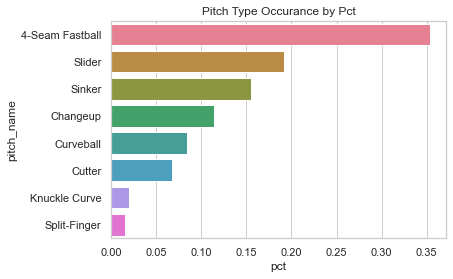

In [20]:
sns.set_theme(style="whitegrid")
sns.barplot(x="pct", y="pitch_name", data=pitch_type, palette='husl')
plt.title('Pitch Type Occurance by Pct')
plt.show()

# compare pitch type breakdown of different zones

In [21]:
# AB
pitchTypeAB = AB['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitchTypeAB['pct'] = pitchTypeAB['counts']/pitchTypeAB['counts'].sum()
pitchTypeAB['zone'] = 'AB'
pitchTypeAB

,pitch_name,counts,pct,zone
0,4-Seam Fastball,179572,0.377642,AB
1,Slider,83031,0.174615,AB
2,Sinker,73420,0.154403,AB
3,Changeup,52679,0.110784,AB
4,Curveball,39354,0.082762,AB
5,Cutter,30529,0.064203,AB
6,Knuckle Curve,9541,0.020065,AB
7,Split-Finger,7383,0.015527,AB


In [22]:
# A
pitchTypeA = A['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitchTypeA['pct'] = pitchTypeA['counts']/pitchTypeA['counts'].sum()
pitchTypeA['zone'] = 'A'
pitchTypeA

,pitch_name,counts,pct,zone
0,4-Seam Fastball,156726,0.380704,A
1,Slider,71071,0.172639,A
2,Sinker,63333,0.153843,A
3,Changeup,45427,0.110347,A
4,Curveball,34197,0.083068,A
5,Cutter,26160,0.063545,A
6,Knuckle Curve,8343,0.020266,A
7,Split-Finger,6417,0.015588,A


In [23]:
# concat AB and A for plotting
pitchTypeABvsA = pd.concat([pitchTypeAB, pitchTypeA]).copy()

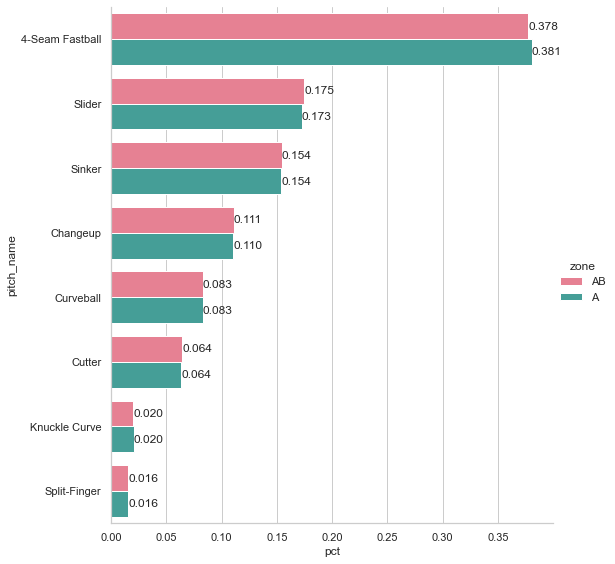

In [24]:
# histogram of contact category
g = sns.catplot(x='pct', y='pitch_name', 
               hue='zone',data=pitchTypeABvsA, kind='bar', palette='husl', height=8)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
# plt.title("Pitch Description Pct from Regular vs Reduced Strikezone")
plt.show()

In [25]:
# C
pitchTypeC = C['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitchTypeC['pct'] = pitchTypeAB['counts']/pitchTypeAB['counts'].sum()
pitchTypeC['zone'] = 'C'
pitchTypeC

,pitch_name,counts,pct,zone
0,4-Seam Fastball,71007,0.377642,C
1,Slider,53041,0.174615,C
2,Sinker,36312,0.154403,C
3,Changeup,28014,0.110784,C
4,Curveball,19909,0.082762,C
5,Cutter,17109,0.064203,C
6,Knuckle Curve,4194,0.020065,C
7,Split-Finger,3505,0.015527,C


In [26]:
# BC
pitchTypeBC = BC['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitchTypeBC['pct'] = pitchTypeBC['counts']/pitchTypeBC['counts'].sum()
pitchTypeBC['zone'] = 'BC'
pitchTypeBC

,pitch_name,counts,pct,zone
0,4-Seam Fastball,93853,0.316082,BC
1,Slider,65001,0.218913,BC
2,Sinker,46399,0.156265,BC
3,Changeup,35266,0.118770,BC
4,Curveball,25066,0.084418,BC
5,Cutter,21478,0.072335,BC
6,Knuckle Curve,5392,0.018159,BC
7,Split-Finger,4471,0.015058,BC


In [27]:
# concat AB and A for plotting
pd.set_option('display.max_rows', None)

pitchTypeCvsBC = pd.concat([pitchTypeC, pitchTypeBC]).copy()
pitchTypeCvsBC

,pitch_name,counts,pct,zone
0,4-Seam Fastball,71007,0.377642,C
1,Slider,53041,0.174615,C
2,Sinker,36312,0.154403,C
3,Changeup,28014,0.110784,C
4,Curveball,19909,0.082762,C
5,Cutter,17109,0.064203,C
6,Knuckle Curve,4194,0.020065,C
7,Split-Finger,3505,0.015527,C
0,4-Seam Fastball,93853,0.316082,BC
1,Slider,65001,0.218913,BC


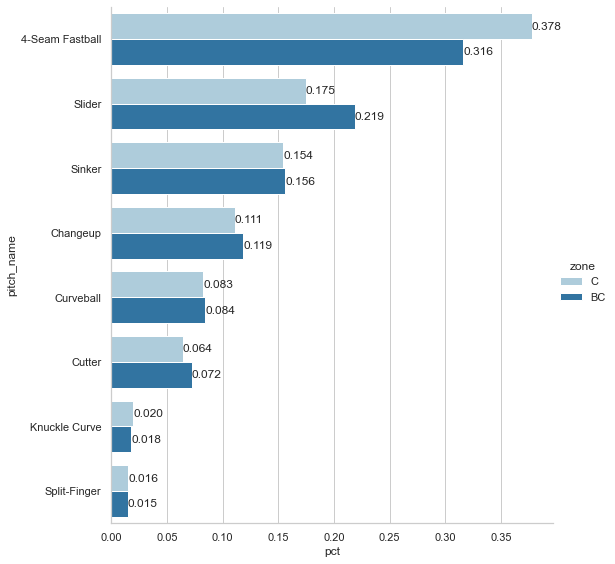

In [28]:
# histogram of contact category

g = sns.catplot(x='pct', y='pitch_name', 
               hue='zone',data=pitchTypeCvsBC, kind='bar', palette='Paired', height=8)
ax = g.facet_axis(0, 0)


for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
# plt.title("Pitch Description Pct from Regular vs Reduced Strikezone")
plt.show()

In [29]:
BC.shape

(296926, 107)

In [30]:
C.shape

(233091, 107)

# resample pitches from BC to match C 

In [31]:
# use slider as benchmark
# total counts = slider counts in BC / slider pct in C
total_over = pitchTypeBC[pitchTypeBC['pitch_name']=='Slider']['counts']/pitchTypeC[pitchTypeC['pitch_name']=='Slider']['pct']
total_over = int(round(total_over))
total_over

372253

In [32]:
# use fastball as benchmark
# total counts = slider counts in BC / slider pct in C
total_under = pitchTypeBC[pitchTypeBC['pitch_name']=='4-Seam Fastball']['counts']/pitchTypeC[pitchTypeC['pitch_name']=='4-Seam Fastball']['pct']
total_under = int(round(total_under))
total_under

248524

In [33]:
resampleChart_BC = pitchTypeBC['pitch_name'].to_frame().copy()
resampleChart_BC['pct_target'] = pitchTypeC['pct']

In [34]:
for index, row in resampleChart_BC.iterrows():
    resampleChart_BC.at[index, 'counts_over'] = round(total_over * row['pct_target'])
    resampleChart_BC.at[index, 'counts_under'] = round(total_under * row['pct_target'])
resampleChart_BC['diff_over'] = resampleChart_BC['counts_over'] - pitchTypeBC['counts']
resampleChart_BC['diff_under'] = resampleChart_BC['counts_under'] - pitchTypeBC['counts']
resampleChart_BC['counts_current'] = pitchTypeBC['counts']
resampleChart_BC['getSample_under'] = resampleChart_BC['counts_current'] + resampleChart_BC['diff_under']

In [35]:
resampleChart_BC

,pitch_name,pct_target,counts_over,counts_under,diff_over,diff_under,counts_current,getSample_under
0,4-Seam Fastball,0.377642,140578.0,93853.0,46725.0,0.0,93853,93853.0
1,Slider,0.174615,65001.0,43396.0,0.0,-21605.0,65001,43396.0
2,Sinker,0.154403,57477.0,38373.0,11078.0,-8026.0,46399,38373.0
3,Changeup,0.110784,41240.0,27533.0,5974.0,-7733.0,35266,27533.0
4,Curveball,0.082762,30808.0,20568.0,5742.0,-4498.0,25066,20568.0
5,Cutter,0.064203,23900.0,15956.0,2422.0,-5522.0,21478,15956.0
6,Knuckle Curve,0.020065,7469.0,4987.0,2077.0,-405.0,5392,4987.0
7,Split-Finger,0.015527,5780.0,3859.0,1309.0,-612.0,4471,3859.0


# undersampling

In [36]:
BC_under = pd.DataFrame()

In [37]:
pitch_list = resampleChart_BC['pitch_name'].to_list()
for pitch in pitch_list:
    sample_num = resampleChart_BC[resampleChart_BC['pitch_name']==pitch]['getSample_under']
    sample_num = int(sample_num)
    df = BC[BC['pitch_name']==pitch].sample(n=sample_num, random_state=0)
    BC_under = pd.concat([BC_under, df])

In [38]:
BC_under.shape

(248525, 107)

# plot pitch type breakdown again

In [39]:
# BC resampled
pitchTypeBC_resampled = BC_under['pitch_name'].value_counts().rename_axis('pitch_name').reset_index(name='counts').copy()
pitchTypeBC_resampled['pct'] = pitchTypeBC_resampled['counts']/pitchTypeBC_resampled['counts'].sum()
pitchTypeBC_resampled['zone'] = 'BC_resampled'
pitchTypeBC_resampled

,pitch_name,counts,pct,zone
0,4-Seam Fastball,93853,0.377640,BC_resampled
1,Slider,43396,0.174614,BC_resampled
2,Sinker,38373,0.154403,BC_resampled
3,Changeup,27533,0.110786,BC_resampled
4,Curveball,20568,0.082760,BC_resampled
5,Cutter,15956,0.064203,BC_resampled
6,Knuckle Curve,4987,0.020066,BC_resampled
7,Split-Finger,3859,0.015528,BC_resampled


In [40]:
# concat C and BC_resampled for plotting
pitchTypeCvsBC_resampled = pd.concat([pitchTypeC, pitchTypeBC_resampled]).copy()
pitchTypeCvsBC_resampled

,pitch_name,counts,pct,zone
0,4-Seam Fastball,71007,0.377642,C
1,Slider,53041,0.174615,C
2,Sinker,36312,0.154403,C
3,Changeup,28014,0.110784,C
4,Curveball,19909,0.082762,C
5,Cutter,17109,0.064203,C
6,Knuckle Curve,4194,0.020065,C
7,Split-Finger,3505,0.015527,C
0,4-Seam Fastball,93853,0.377640,BC_resampled
1,Slider,43396,0.174614,BC_resampled


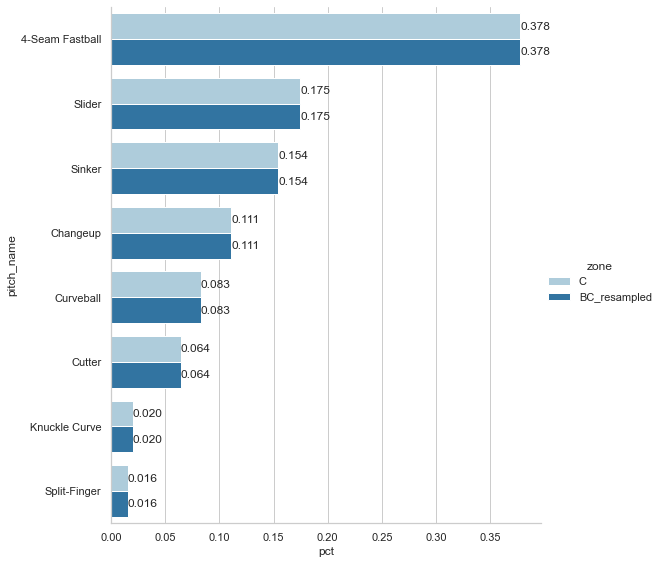

In [41]:
# histogram of contact category

g = sns.catplot(x='pct', y='pitch_name', 
               hue='zone',data=pitchTypeCvsBC_resampled, kind='bar', palette='Paired', height=8)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
# plt.title("Pitch Description Pct from Regular vs Reduced Strikezone")
plt.show()

# plot pitch event breakdown for each zone

In [43]:
AB['description'].isna().sum()

0

In [44]:
# AB
pitchEventAB = AB['description'].value_counts().rename_axis('description').reset_index(name='counts').copy()
pitchEventAB['pct'] = pitchEventAB['counts']/pitchEventAB['counts'].sum()
pitchEventAB['zone'] = 'AB'
pitchEventAB

,description,counts,pct,zone
0,hit_into_play,105443,0.221748,AB
1,foul,104950,0.220711,AB
2,called_strike,102781,0.216149,AB
3,ball,87328,0.183652,AB
4,swinging_strike,56362,0.118530,AB
5,blocked_ball,8458,0.017787,AB
6,foul_tip,5561,0.011695,AB
7,swinging_strike_blocked,3035,0.006383,AB
8,foul_bunt,1288,0.002709,AB
9,missed_bunt,258,0.000543,AB


In [52]:
# A
pitchEventA = A['description'].value_counts().rename_axis('description').reset_index(name='counts').copy()
pitchEventA['pct'] = pitchEventA['counts']/pitchEventA['counts'].sum()
pitchEventA['zone'] = 'A'
pitchEventA

,description,counts,pct,zone
0,hit_into_play,94803,0.230287,A
1,foul,93516,0.227160,A
2,called_strike,87496,0.212537,A
3,ball,70459,0.171152,A
4,swinging_strike,49354,0.119886,A
5,blocked_ball,7083,0.017205,A
6,foul_tip,4955,0.012036,A
7,swinging_strike_blocked,2601,0.006318,A
8,foul_bunt,1143,0.002776,A
9,missed_bunt,226,0.000549,A


In [53]:
# concat
pitchEventAvsAB = pd.concat([pitchEventA, pitchEventAB]).copy()
pitchEventAvsAB

,description,counts,pct,zone
0,hit_into_play,94803,0.230287,A
1,foul,93516,0.227160,A
2,called_strike,87496,0.212537,A
3,ball,70459,0.171152,A
4,swinging_strike,49354,0.119886,A
5,blocked_ball,7083,0.017205,A
6,foul_tip,4955,0.012036,A
7,swinging_strike_blocked,2601,0.006318,A
8,foul_bunt,1143,0.002776,A
9,missed_bunt,226,0.000549,A


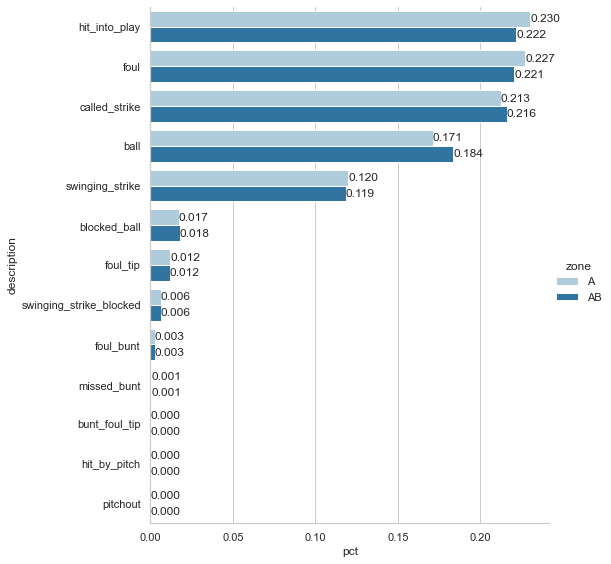

In [54]:
# catplot of A and AB

g = sns.catplot(x='pct', y='description', 
               hue='zone',data=pitchEventAvsAB, kind='bar', palette='Paired', height=8)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
# plt.title("Pitch Description Pct from Regular vs Reduced Strikezone")
plt.show()

In [55]:
# C
pitchEventC = C['description'].value_counts().rename_axis('description').reset_index(name='counts').copy()
pitchEventC['pct'] = pitchEventC['counts']/pitchEventC['counts'].sum()
pitchEventC['zone'] = 'C'
pitchEventC

,description,counts,pct,zone
0,ball,149147,0.639866,C
1,foul,20854,0.089467,C
2,swinging_strike,19290,0.082757,C
3,hit_into_play,15974,0.068531,C
4,called_strike,13621,0.058436,C
5,blocked_ball,8846,0.037951,C
6,hit_by_pitch,2099,0.009005,C
7,swinging_strike_blocked,1675,0.007186,C
8,foul_tip,1163,0.004989,C
9,foul_bunt,281,0.001206,C


In [56]:
# BC_resampled
pitchEventBC_resampled = BC_under['description'].value_counts().rename_axis('description').reset_index(name='counts').copy()
pitchEventBC_resampled['pct'] = pitchEventBC_resampled['counts']/pitchEventBC_resampled['counts'].sum()
pitchEventBC_resampled['zone'] = 'BC_resampled'
pitchEventBC_resampled

,description,counts,pct,zone
0,ball,140089,0.563682,BC_resampled
1,foul,27274,0.109743,BC_resampled
2,called_strike,24969,0.100469,BC_resampled
3,hit_into_play,22375,0.090031,BC_resampled
4,swinging_strike,20727,0.083400,BC_resampled
5,blocked_ball,7761,0.031228,BC_resampled
6,hit_by_pitch,1748,0.007033,BC_resampled
7,swinging_strike_blocked,1582,0.006366,BC_resampled
8,foul_tip,1497,0.006024,BC_resampled
9,foul_bunt,360,0.001449,BC_resampled


In [57]:
# concat
pitchEventCvsBC_resampled = pd.concat([pitchEventBC_resampled, pitchEventC]).copy()

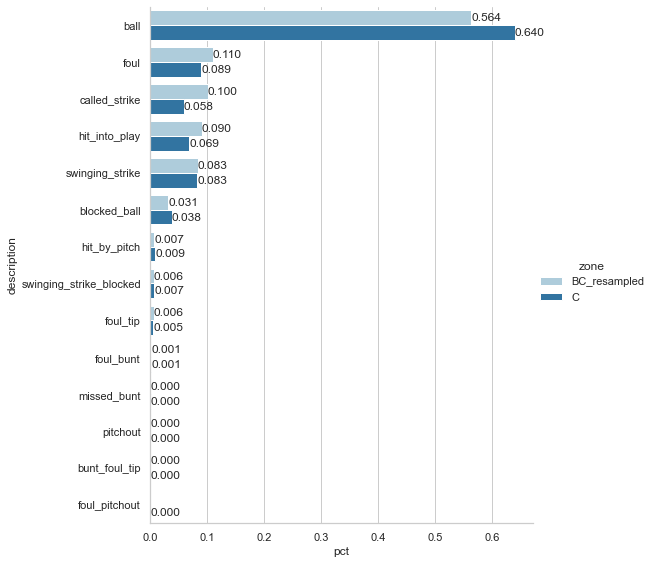

In [58]:
# catplot of A and AB

g = sns.catplot(x='pct', y='description', 
               hue='zone',data=pitchEventCvsBC_resampled, kind='bar', palette='Paired', height=8)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
# plt.title("Pitch Description Pct from Regular vs Reduced Strikezone")
plt.show()

# prediction

In [94]:
data_full.shape

(709483, 107)

In [85]:
numPitchA = A.shape[0]

In [86]:
numPitchBC = BC.shape[0]

In [63]:
event_pred = pitchEventC['description'].to_frame().copy()

In [98]:
event_pred['A_counts'] = round(pitchEventA['pct'] * numPitchA)
event_pred['BC_counts'] = round(pitchEventBC_resampled['pct'] * numPitchBC)
event_pred['total_counts'] = event_pred['A_counts'] + event_pred['BC_counts']
event_pred['countsGame'] = event_pred['total_counts']/4858

In [99]:
event_pred

,description,A_counts,BC_counts,total_counts,countsGame
0,ball,94803.0,167372.0,262175.0,53.967682
1,foul,93516.0,32586.0,126102.0,25.957596
2,swinging_strike,87496.0,29832.0,117328.0,24.151503
3,hit_into_play,70459.0,26733.0,97192.0,20.006587
4,called_strike,49354.0,24764.0,74118.0,15.256896
5,blocked_ball,7083.0,9272.0,16355.0,3.366612
6,hit_by_pitch,4955.0,2088.0,7043.0,1.449774
7,swinging_strike_blocked,2601.0,1890.0,4491.0,0.924455
8,foul_tip,1143.0,1789.0,2932.0,0.603541
9,foul_bunt,226.0,430.0,656.0,0.135035
